In [0]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C, DotProduct, Matern

sigma = 10
n_for_b = {
        1: (lambda x: 100 * (1.0 - np.exp(-5 * x + x ** 2 + 1 * x ** 3))),
        2: (lambda x: 75 * (1.0 - np.exp(-5 * x + 2 * x ** 3))),
        3: (lambda x: 100 * (1.0 - np.exp(-4 * x + 1 * x ** 3)))
}

min_budget = 0.0
max_budget = 1.0

Dalla documentazione, sommare al kernel WhiteKernel(noise_level=alpha**2, noise_level_bounds= (1,200)) dovrebbe essere equivalente ad alpha e dovrebbe pure permettere al processo di imparare alpha, ma questo è errato, in quanto la varianza del whitekernel viene inserita anche nella predizione! 
Questo alpha ha due effetti: 

1) jittering per assicurare che la matrice sia definita positiva per la decomposizione di Cholesky 

2) Ha un ruolo di controllo sulla regolarità della curva imparata e, in parte, determina l'incertezza sulla predizione. Con alpha maggiore, si avrà una curva più liscia, ma tendenzialmente IC più ampi, con un MSE più alto. Se si vuole abbattere l'MSE, è bene portarlo più vicino a 0.

NB Il valore di alpha ha un grosso effetto sugli iperparametri ottenuti, dunque è necessario trovare il valore migliore per avere i migliori iperparametri e, poi, utilizzarlo anche nell'effettivo training del GP


In [0]:
rng = np.random.seed(0)
alpha = 5
#kernel = C(1e2, (1e-2, 1e4)) * RBF(length_scale = 1e-1, length_scale_bounds= (1e-5, 1e5)) + WhiteKernel(noise_level=alpha**2, noise_level_bounds='fixed')
#kernel = C(1e2, constant_value_bounds = (2*1e1, 2*1e2)) * RBF(length_scale = 1e-1, length_scale_bounds= (1e-2, 1e1))
kernel = C(14.1**2, constant_value_bounds = 'fixed') * RBF(length_scale = 0.271, length_scale_bounds= 'fixed') 


##DotProduct(200, sigma_0_bounds = 'fixed') Matern(length_scale=1.0, nu=1.5) , altri kernel a caso da testare che non fanno male

#gp = GaussianProcessRegressor(kernel=kernel, alpha=alpha ** 2, normalize_y = False, n_restarts_optimizer = 9, random_state = rng)
gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha**2, normalize_y = True, n_restarts_optimizer = 9, random_state = rng) #optimizer = None)
gp = GaussianProcessRegressor(kernel=kernel, alpha = alpha**2, normalize_y = True, n_restarts_optimizer = 0, random_state = rng, optimizer = None)

Tendenzialmente, ridurre gli intervalli di ricerca degli iperparametri migliora la convergenza a 'buoni' iperparametri. è bene ricordare che il processo di ottimizzazione è stocastico, quindi va settato il seed per la riproducibilità.

Nel kernel costante, l'iperparametro ottimale da inserire è x**2, come trovato in fondo.

In [439]:
x = np.linspace(min_budget, max_budget, 25)
x = np.repeat(x, 50)

y = np.random.normal(n_for_b[1](x), sigma)
### non può diventare negativo
#y = abs(y) -> ma tenere conto che così sovrastimiamo i valori bassi

x_fit = np.atleast_2d(x).T
gp.fit(x_fit, y)

GaussianProcessRegressor(alpha=25, copy_X_train=True,
                         kernel=14.1**2 * RBF(length_scale=0.271),
                         n_restarts_optimizer=0, normalize_y=True,
                         optimizer=None, random_state=None)

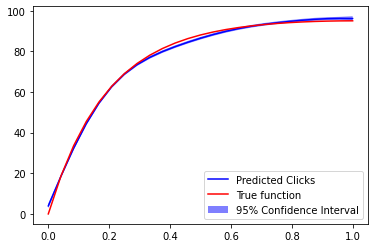

In [440]:
y_pred, sigma = gp.predict(x_fit, return_std=True)

import matplotlib.pyplot as plt

plt.plot(x_fit, y_pred, 'b-', label=u'Predicted Clicks')
plt.fill(np.concatenate([x_fit, x_fit[::-1]]),
         np.concatenate([y_pred - 1.96 * sigma, (y_pred + 1.96 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% Confidence Interval')
plt.plot(x, n_for_b[1](x), 'r', label='True function')
plt.legend()

In [441]:
gp.get_params(False)

{'alpha': 25,
 'copy_X_train': True,
 'kernel': 14.1**2 * RBF(length_scale=0.271),
 'n_restarts_optimizer': 0,
 'normalize_y': True,
 'optimizer': None,
 'random_state': None}

In [442]:
gp.kernel_

14.1**2 * RBF(length_scale=0.271)

In [443]:
np.linalg.norm(y_pred - y)

344.84948014105083

Iperparametri molto grandi nel kernel costante ingigantiscono la grandezza degli intervalli di confidenza e rendono la funzione più irregolare (ha senso a intuito perché danno meno peso all'effetto smoothing del kernel rbf).

Riguardo l'iperparametro del kernel rbf, invece, se l'iperparametro è grande, la funzione vorrà essere 'troppo regolare' e non riuscirà a fittare la curva. Se è troppo piccolo rispetto all'iperparametro del kernel costante, non riuscirà a fornire l'effetto regolarizzante. Mai metterlo > 1.

Vi è dunque da bilanciare entrambi gli effetti, considerando se si vuole una funzione più liscia o interpolante maggiormente i risultati trovati.

